# Part 2: Rotten Tomatoes Data Modeling
In this section, we will explore a variety of data models to predict whether the review is Fresh (1) or Rotten (0). 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#evaluate model
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, roc_curve, auc)

In [3]:
df = pd.read_csv('../data/rt_new_features.csv')
df.head(3)

,rt_review,rt_target,char_length,word_count,rt_label,afinn_score,afinn_type
0,"simplistic , silly and tedious .",0,33,6,Rotten,-1.0,Negative
1,"it's so laddish and juvenile , only teenage bo...",0,80,15,Rotten,4.0,Positive
2,exploitative and largely devoid of the depth o...,0,138,22,Rotten,-3.0,Negative


### Baseline Accuracy

In [4]:
df.rt_label.value_counts(normalize=True)

Rotten    0.5
Fresh     0.5
Name: rt_label, dtype: float64

The **baseline** accuracy of this dataset is 50% (data is perfectly balanced between two classes for our target - Rotten, Fresh).

In [5]:
def get_preds_df(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    results = pd.merge(X_test,y_test, left_index=True, right_index=True).reset_index()
    results['prediction'] = y_preds
    results['outcome'] = results['prediction'] == results['rt_label']
    return results


def get_metrics(name,model, X_train, y_train, X_test, y_test):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    recall = recall_score(y_test, preds, pos_label="Fresh")
    precision = precision_score(y_test, preds, pos_label="Fresh")
    acc = accuracy_score(y_test, preds)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    metrics = {
               'Model':name,
               'Train Accuracy': model.score(X_train,y_train),
               'Accuracy': acc, 
               'TP': tp,
               'FP' :fp, 
               'TN': tn,
               "FN": fn,
               "Precision": precision,
               "Sensitivity": sens,
               "Specificity": spec,
               "Recall": recall}
    df = pd.DataFrame(metrics.items()).T
    df.columns = df.iloc[0]
    df = df[1:]
    return df

## Data Model - Only Text Data

In [6]:
X = df['rt_review']
y = df['rt_label']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y, test_size=0.15)

#### LogReg & CountVectorizer

In [7]:
pipe_cv_log = Pipeline([
    ('cv',CountVectorizer()),
    ('log', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

#fite
pipe_cv_log.fit(X_train,y_train)

#evaluate
get_metrics("Logistic Regression with CountVectorizer",pipe_cv_log, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,Logistic Regression with CountVectorizer,0.934783,0.7725,623,187,613,177,0.775949,0.77875,0.76625,0.76625


/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


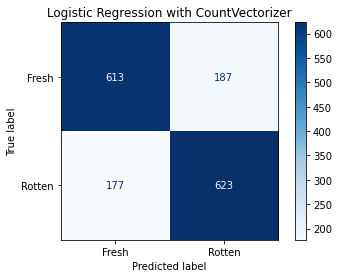

In [8]:
plot_confusion_matrix(pipe_cv_log, X_test, y_test, cmap="Blues")
plt.title("Logistic Regression with CountVectorizer");

### LogReg & TfidVec

In [9]:
#instantiate
pipe_tf_log = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('logreg', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

#fit
pipe_tf_log.fit(X_train,y_train)

#evaluate
get_metrics("Logistic Regression with TfidVectorizer",pipe_tf_log, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,Logistic Regression with TfidVectorizer,0.940852,0.781875,630,179,621,170,0.785082,0.7875,0.77625,0.77625


/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


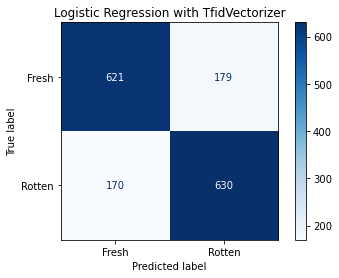

In [10]:
plot_confusion_matrix(pipe_tf_log, X_test, y_test, cmap="Blues")
plt.title("Logistic Regression with TfidVectorizer");

### GridSearch with LogReg Tfid

In [11]:
tfv_logreg_params  = {
    'tfv__stop_words': [None,"english"],
    'tfv__min_df': [1,2,3],
    'tfv__ngram_range': [(1, 1),(2,2),(1,2)]
}

tfv_log_gs = GridSearchCV(pipe_tf_log, param_grid=tfv_logreg_params)
tfv_log_gs.fit(X_train, y_train)
print(tfv_log_gs.best_score_)
tfv_log_gs.best_params_

0.7765404139103288


{'tfv__min_df': 1, 'tfv__ngram_range': (1, 2), 'tfv__stop_words': None}

### Random Forest Classifiers

In [12]:
pipe_tf_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))]
)

pipe_tf_rfc.fit(X_train,y_train)
get_metrics("Random Forest Classifier with TFV",pipe_tf_rfc, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,Random Forest Classifier with TFV,1.0,0.70125,575,253,547,225,0.708549,0.71875,0.68375,0.68375


In [13]:
pipe_cv_rfc = Pipeline([
    ('cv',CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))]
)

pipe_cv_rfc.fit(X_train,y_train)
get_metrics("Random Forest Classifier with CV",pipe_cv_rfc, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,Random Forest Classifier with CV,1.0,0.701875,574,251,549,226,0.708387,0.7175,0.68625,0.68625


### MultiNomial NaiveBayes

In [14]:
pipe_tf_mnb = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('mnb', MultinomialNB())]
)

pipe_tf_mnb.fit(X_train,y_train)
get_metrics("MultiNomial NB with TFV",pipe_tf_mnb, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,MultiNomial NB with TFV,0.926506,0.774375,637,198,602,163,0.786928,0.79625,0.7525,0.7525


### KNN

In [15]:
pipe_tfv_knn = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('knn', KNeighborsClassifier())]
)

pipe_tfv_knn.fit(X_train,y_train)
get_metrics("KNN with TFV",pipe_tfv_knn, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,KNN with TFV,0.825866,0.708125,557,224,576,243,0.703297,0.69625,0.72,0.72


### SVM

In [16]:
pipe_tfv_svm = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))]
)

pipe_tfv_svm.fit(X_train,y_train)
    
get_metrics("SVM with TFV",pipe_tfv_svm, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,SVM with TFV,0.935665,0.785,645,189,611,155,0.79765,0.80625,0.76375,0.76375


In [17]:
results = pd.concat(
[get_metrics("Logistic Regression with CV",pipe_cv_log, X_train, y_train, X_test, y_test),
get_metrics("Logistic Regression with TFV",pipe_tf_log, X_train, y_train, X_test, y_test),
get_metrics("MultiNomial NB with TFV",pipe_tf_mnb, X_train, y_train, X_test, y_test),
get_metrics("KNN with TFV",pipe_tfv_knn, X_train, y_train, X_test, y_test),
get_metrics("SVM with TFV",pipe_tfv_svm, X_train, y_train, X_test, y_test),
get_metrics("Random Forest Classifier with CV",pipe_cv_rfc, X_train, y_train, X_test, y_test),
get_metrics("Random Forest Classifier with TFV",pipe_tf_rfc, X_train, y_train, X_test, y_test)]
)

results 

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,Logistic Regression with CV,0.934783,0.7725,623,187,613,177,0.775949,0.77875,0.76625,0.76625
1,Logistic Regression with TFV,0.940852,0.781875,630,179,621,170,0.785082,0.7875,0.77625,0.77625
1,MultiNomial NB with TFV,0.926506,0.774375,637,198,602,163,0.786928,0.79625,0.7525,0.7525
1,KNN with TFV,0.825866,0.708125,557,224,576,243,0.703297,0.69625,0.72,0.72
1,SVM with TFV,0.935665,0.785,645,189,611,155,0.79765,0.80625,0.76375,0.76375
1,Random Forest Classifier with CV,1.0,0.701875,574,251,549,226,0.708387,0.7175,0.68625,0.68625
1,Random Forest Classifier with TFV,1.0,0.70125,575,253,547,225,0.708549,0.71875,0.68375,0.68375


In [18]:
results.to_csv("../data/results_just_text.csv")

## Data Model - Text & Quantitative Data (Affin Score)

In [19]:
cv = CountVectorizer(stop_words=None,
                         ngram_range = (1,1),
                         min_df= 1)
cv.fit(df['rt_review'])
cv_text = cv.transform(df['rt_review'])
df_cv = pd.DataFrame(cv_text.todense(),columns=cv.get_feature_names())
cv_data = pd.merge(df, df_cv, left_index=True, right_index=True)
cv_data.head(3)

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rt_review,rt_target,char_length,word_count,rt_label,afinn_score,afinn_type,00,000,007,...,zwick,zzzzzzzzz,às,ápice,élan,ótimo,último,últimos,única,único
0,"simplistic , silly and tedious .",0,33,6,Rotten,-1.0,Negative,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"it's so laddish and juvenile , only teenage bo...",0,80,15,Rotten,4.0,Positive,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,exploitative and largely devoid of the depth o...,0,138,22,Rotten,-3.0,Negative,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X2 = cv_data.drop(columns = ['rt_review','rt_target','rt_label','afinn_type'])
y2 = cv_data['rt_label']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state=42, stratify=y, test_size=0.2)

In [21]:
logreg = LogisticRegressionCV(solver='liblinear', max_iter=1000)

logreg.fit(X_train2, y_train2)

get_metrics("LogReg Full Data",logreg, X_train2, y_train2, X_test2, y_test2)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,LogReg Full Data,0.927541,0.766057,837,270,797,229,0.776803,0.785178,0.746954,0.746954


In [22]:
TfidfVectorizer()

tfv = TfidfVectorizer(stop_words=None,
                         ngram_range = (1,1),
                         min_df= 1)
tfv.fit(df['rt_review'])
tfv_text = tfv.transform(df['rt_review'])
df_tfv = pd.DataFrame(tfv_text.todense(),columns=cv.get_feature_names())
tfv_data = pd.merge(df, df_tfv, left_index=True, right_index=True)
tfv_data.head(3)

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rt_review,rt_target,char_length,word_count,rt_label,afinn_score,afinn_type,00,000,007,...,zwick,zzzzzzzzz,às,ápice,élan,ótimo,último,últimos,única,único
0,"simplistic , silly and tedious .",0,33,6,Rotten,-1.0,Negative,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"it's so laddish and juvenile , only teenage bo...",0,80,15,Rotten,4.0,Positive,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,exploitative and largely devoid of the depth o...,0,138,22,Rotten,-3.0,Negative,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X3 = tfv_data.drop(columns = ['rt_review','rt_target','rt_label','afinn_type'])
y3 = tfv_data['rt_label']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, random_state=42, stratify=y, test_size=0.2)

In [24]:
logreg2 = LogisticRegressionCV(solver='liblinear', max_iter=1000)

logreg2.fit(X_train3, y_train3)

get_metrics("LogReg with TFV - Full Data",logreg2, X_train3, y_train3, X_test3, y_test3)

,Model,Train Accuracy,Accuracy,TP,FP,TN,FN,Precision,Sensitivity,Specificity,Recall
1,LogReg with TFV - Full Data,0.933521,0.772152,831,251,816,235,0.776403,0.77955,0.764761,0.764761


## Misclassification Analysis

In [28]:
preds = get_preds_df(pipe_tfv_svm, X_train, y_train, X_test, y_test)
preds.head(3)

,index,rt_review,rt_label,prediction,outcome
0,1681,minority report is exactly what the title indi...,Rotten,Rotten,True
1,2076,. . . ( like ) channel surfing between the di...,Rotten,Rotten,True
2,9421,worth a salute just for trying to be more comp...,Fresh,Fresh,True


In [38]:
misclass = preds[preds.outcome==False]
list(misclass[misclass.rt_label=='Fresh']['rt_review'])[0:5]

["it's so good that you can practically see the hollywood 'suits' trying to put together the cast and filmmaking team for the all-too -inevitable american remake . ",
 'grant is certainly amusing , but the very hollowness of the character he plays keeps him at arms length',
 "its maker , steven spielberg , hasn't had so much fun in two decades , since he was schlepping indiana jones around the globe in search of a giant misplaced ashtray . ",
 'by not averting his eyes , solondz forces us to consider the unthinkable , the unacceptable , the unmentionable . ',
 'as underwater ghost stories go , below casts its spooky net out into the atlantic ocean and spits it back , grizzled and charred , somewhere northwest of the bermuda triangle . ']

In [39]:
misclass = preds[preds.outcome==False]
list(misclass[misclass.rt_label=='Rotten']['rt_review'])[0:5]

['about as satisfying and predictable as the fare at your local drive through . ',
 "'ejemplo de una cinta en que no importa el talento de su reparto o lo interesante que pudo haber resultado su premisa , pues el resultado es francamente aburrido y , por momentos , deplorable . '",
 "although purportedly a study in modern alienation , it's really little more than a particularly slanted , gay s/m fantasy , enervating and deadeningly drawn-out . ",
 'this is for the most part a useless movie , even with a great director at the helm . ',
 'innocuous enough to make even jean-claude van damme look good . ']

### Export Model as Pickle File

In [ ]:
#import pickle
#with open('../model/svm_pipe.pkl', 'wb') as pickle_out:
#    pickle_out = pickle.dump(pipe_tfv_svm, pickle_out)